#### Part 1: Volatility Prediction using LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

import seaborn as sns

from sqlalchemy import create_engine

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


Load and Prepare Data from PostgreSQL for multiple assests

In [2]:
# PostgreSQL connection
engine = create_engine('postgresql://akilfiros:@127.0.0.1:5432/postgres')

In [3]:
# Load processed data from PostgreSQL
query = "SELECT date, ticker, close FROM financial_data"
data = pd.read_sql(query, engine)
data['date'] = pd.to_datetime(data['date'])

In [4]:
# Pivot: rows = date, columns = ticker, values = close prices
prices = data.pivot(index='date', columns='ticker', values='close').sort_index()

# Drop tickers with missing data (optional: can use interpolation instead)
prices = prices.dropna(axis=1)

# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Calculate 10-day rolling volatility per asset
volatility = log_returns.rolling(window=10).std().dropna()

# Preview one asset’s return and volatility
sample_ticker = volatility.columns[0]  # e.g., 'AAPL' 
#if you want to change the asset then change the columns number in the sample_ticker ,for e.g. column[0] = AAPL
df = pd.DataFrame({
    'LogReturn': log_returns[sample_ticker],
    'Volatility': volatility[sample_ticker]
}).dropna()


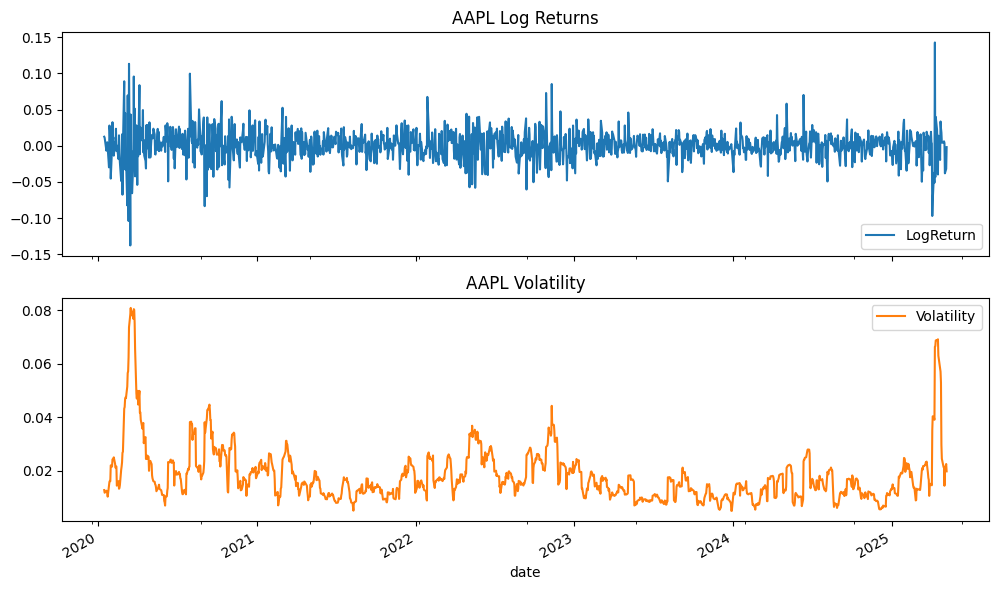

In [5]:
# Plot sample ticker return and volatility
df.plot(subplots=True, title=[f"{sample_ticker} Log Returns", f"{sample_ticker} Volatility"], figsize=(10, 6))
plt.tight_layout()
plt.show()

Preparing the for LSTM for each asset 

In [6]:
# We'll store data for each ticker separately
sequence_data = {}

SEQ_LEN = 30

for ticker in volatility.columns:
    # Combine log returns and volatility for the asset
    asset_df = pd.DataFrame({
        'LogReturn': log_returns[ticker],
        'Volatility': volatility[ticker]
    }).dropna()
    
    # Scale volatility
    scaler = MinMaxScaler()
    scaled_vol = scaler.fit_transform(asset_df[['Volatility']])
    
    # Create sequences
    X, y = [], []
    for i in range(SEQ_LEN, len(scaled_vol)):
        X.append(scaled_vol[i-SEQ_LEN:i])
        y.append(scaled_vol[i])
    
    # Only add if sufficient data exists
    if len(X) > 0:
        X = np.array(X)
        y = np.array(y)
        split = int(0.8 * len(X))
        sequence_data[ticker] = {
            'X_train': X[:split],
            'X_test': X[split:],
            'y_train': y[:split],
            'y_test': y[split:],
            'scaler': scaler
        }

# Show available tickers with sufficient data
print(f"Prepared LSTM-ready data for {len(sequence_data)} assets:")
print(list(sequence_data.keys())[:5])  # Show sample tickers


Prepared LSTM-ready data for 92 assets:
['AAPL', 'ADBE', 'ADI', 'ADP', 'AEP']


In [7]:
# # Dictionary to hold trained models and their training history
# trained_models = {}
# training_histories = {}

# # Optional: limit the number of assets for speed during development
# max_assets_to_train = 5

# for i, (ticker, data) in enumerate(sequence_data.items()):
#     if i >= max_assets_to_train:
#         break

#     print(f"\n🔧 Training LSTM model for: {ticker}")
#     X_train, X_test = data['X_train'], data['X_test']
#     y_train, y_test = data['y_train'], data['y_test']

#     # Build LSTM model
#     model = Sequential([
#         LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], 1)),
#         Dropout(0.2),
#         Dense(1)
#     ])
    
#     model.compile(optimizer='adam', loss='mse')

#     # Early stopping to prevent overfitting
#     early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

#     # Train model
#     history = model.fit(
#         X_train, y_train,
#         validation_data=(X_test, y_test),
#         epochs=20,
#         batch_size=32,
#         callbacks=[early_stop],
#         verbose=1
#     )

#     # Save model and training history
#     trained_models[ticker] = model
#     training_histories[ticker] = history

# Create directory to save models if not exists
os.makedirs("models", exist_ok=True)

trained_models = {}
training_histories = {}

# Loop through all tickers in sequence_data
for i, (ticker, data) in enumerate(sequence_data.items(), 1):
    try:
        print(f"\n🔧 Training LSTM model for: {ticker} ({i}/{len(sequence_data)})")

        X_train, X_test = data['X_train'], data['X_test']
        y_train, y_test = data['y_train'], data['y_test']

        # Build model
        model = Sequential([
            LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=20,
            batch_size=32,
            callbacks=[early_stop],
            verbose=0  # Set to 1 if you want to see each epoch
        )

        # Save model to disk
        model_path = f"models/{ticker}_lstm.keras"
        model.save(model_path)

        print(f"✅ Model saved: {model_path}")

        # Optionally store in memory (for later use)
        trained_models[ticker] = model
        training_histories[ticker] = history

        # Clear memory
        del model
        gc.collect()

    except Exception as e:
        print(f"❌ Skipping {ticker} due to error: {e}")


🔧 Training LSTM model for: AAPL (1/92)


/opt/anaconda3/envs/conda_python_env_3.11.10/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


✅ Model saved: models/AAPL_lstm.keras

🔧 Training LSTM model for: ADBE (2/92)
✅ Model saved: models/ADBE_lstm.keras

🔧 Training LSTM model for: ADI (3/92)
✅ Model saved: models/ADI_lstm.keras

🔧 Training LSTM model for: ADP (4/92)
✅ Model saved: models/ADP_lstm.keras

🔧 Training LSTM model for: AEP (5/92)
✅ Model saved: models/AEP_lstm.keras

🔧 Training LSTM model for: ALGN (6/92)
✅ Model saved: models/ALGN_lstm.keras

🔧 Training LSTM model for: AMAT (7/92)
✅ Model saved: models/AMAT_lstm.keras

🔧 Training LSTM model for: AMD (8/92)
✅ Model saved: models/AMD_lstm.keras

🔧 Training LSTM model for: AMGN (9/92)
✅ Model saved: models/AMGN_lstm.keras

🔧 Training LSTM model for: AMZN (10/92)
✅ Model saved: models/AMZN_lstm.keras

🔧 Training LSTM model for: ANSS (11/92)
✅ Model saved: models/ANSS_lstm.keras

🔧 Training LSTM model for: AVGO (12/92)
✅ Model saved: models/AVGO_lstm.keras

🔧 Training LSTM model for: AXON (13/92)
✅ Model saved: models/AXON_lstm.keras

🔧 Training LSTM model for: AZ

Evaluation metric for the LSTM model 

In [8]:
# Store evaluation results
evaluation_results = {}

for ticker, data in sequence_data.items():
    try:
        print(f"\n📈 Evaluating LSTM model for: {ticker}")
        
        # Load saved model
        model = load_model(f"models/{ticker}_lstm.keras")

        # Get data and scaler
        X_test = data['X_test']
        y_test = data['y_test']
        scaler = data['scaler']

        # Predict
        predicted_scaled = model.predict(X_test)
        predicted_vol = scaler.inverse_transform(predicted_scaled)
        actual_vol = scaler.inverse_transform(y_test)

        # Compute metrics
        rmse = root_mean_squared_error(actual_vol, predicted_vol)
        mae = mean_absolute_error(actual_vol, predicted_vol)

        # Store
        evaluation_results[ticker] = {'rmse': rmse, 'mae': mae}
        print(f"📊 {ticker} - RMSE: {rmse:.6f}, MAE: {mae:.6f}")

    except Exception as e:
        print(f"❌ Failed to evaluate {ticker}: {e}")


📈 Evaluating LSTM model for: AAPL
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
📊 AAPL - RMSE: 0.003940, MAE: 0.002332

📈 Evaluating LSTM model for: ADBE
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 ADBE - RMSE: 0.006181, MAE: 0.003582

📈 Evaluating LSTM model for: ADI
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 ADI - RMSE: 0.004975, MAE: 0.003122

📈 Evaluating LSTM model for: ADP
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 ADP - RMSE: 0.002206, MAE: 0.001549

📈 Evaluating LSTM model for: AEP
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 AEP - RMSE: 0.002002, MAE: 0.001453

📈 Evaluating LSTM model for: ALGN
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 ALGN - RMSE: 0.004296, MAE: 0.003045

📈 Evaluating LSTM model for: AMAT
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 AMAT - RMSE: 0.005499, MAE: 0.003859

📈 Evaluating LSTM model for: AMD
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 AMD - RMSE: 0.005798, MAE: 0.003296

📈 Evaluating LSTM model for: AMGN
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
📊 AMGN - RMSE: 0.003690, MAE: 0.002236



In [9]:
# # Select ticker to visualize
# tickers = [
#     "AAPL", "MSFT", "AMZN", "NVDA", "GOOG", "GOOGL", "META", "TSLA", "PEP", "AVGO",
#     "COST", "CSCO", "ADBE", "NFLX", "CMCSA", "AMD", "QCOM", "INTC", "HON",
#     "INTU", "AMGN", "SBUX", "AMAT", "MDLZ", "ADI", "ISRG", "BKNG", "LRCX", "GILD",
#     "ADP", "VRTX", "MU", "REGN", "KLAC", "MRVL", "SNPS", "PANW", "CDNS",
#     "CSX", "MELI", "MNST", "LULU", "FTNT", "NXPI", "KDP", "ORLY", "MAR",
#     "CTAS", "PAYX", "EXC", "ODFL", "TEAM", "XEL", "FAST", "BIIB", "ROST", "CTSH",
#     "CHTR", "DLTR", "PCAR", "VRSK", "WBD", "AEP", "IDXX", "MCHP", "AZN", "EA",
#     "ANSS", "ALGN", "KHC", "BKR", "CDW", "DDOG", "CPRT", "CRWD", "DXCM",
#     "ZS", "CEG", "GFS", "PLTR", "MSTR", "AXON", "ARM", "SMCI", "APP",
#     "GEHC", "ON", "TTWO", "PDD", "RIVN", "WBA", "ILMN", "LCID", "OKTA", "NTES",
#     "BIDU", "DOCU", "MTCH", "VRSN", "TCOM"
# ]  # You can replace this with any ticker from sequence_data

# # Load model
# model = load_model(f"models/{ticker}_lstm.keras", compile=False)

# # Get test data
# X_test = sequence_data[ticker]['X_test']
# y_test = sequence_data[ticker]['y_test']
# scaler = sequence_data[ticker]['scaler']

# # Predict
# predicted_scaled = model.predict(X_test)
# predicted_vol = scaler.inverse_transform(predicted_scaled)
# actual_vol = scaler.inverse_transform(y_test)

# # Plot
# plt.figure(figsize=(12, 5))
# plt.plot(actual_vol, label="Actual Volatility", linewidth=2)
# plt.plot(predicted_vol, label="Predicted Volatility", linestyle='--')
# plt.title(f"{ticker} - Actual vs Predicted Volatility (LSTM)")
# plt.xlabel("Time Steps")
# plt.ylabel("Volatility")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
